In [10]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/fscratch/conda/tp2/lib/python3.10/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['step', 'e', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [11]:
import pandas as pd

In [1]:
from tensorpotential.calculator import grace_fm, TPCalculator

[tensorpotential] Info: Environment variable TF_USE_LEGACY_KERAS is automatically set to '1'.


2026-02-23 17:39:30.727960: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-23 17:39:30.739972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771864770.753903 2243542 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771864770.758073 2243542 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771864770.768747 2243542 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
from amstools import *

In [3]:
from amstools.sources import fetch_structures

In [4]:
ref_df=fetch_mp_reference_df(['Al','Li'], 
                             # mp_api_key=MP_API_KEY,
                             max_atoms=32,
                             cache_dir='../../1-AlLi-GRACE-2LAYER/0-data/AlLi_Materials_Project/')

In [5]:
ref_df

,name,ase_atoms,e_per_atom,e_formation_per_atom,e_chull_dist_per_atom
0,Al__mp-1183144,"(Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('A...",NaN,0.010481,0.010481
1,Al__mp-2647008,"(Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('A...",NaN,0.032078,0.032078
2,Al__mp-134,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",NaN,0.000000,0.000000
3,Li__mp-567337,"(Atom('Li', [-0.9218888897176146, 2.8025429460...",NaN,0.008819,0.008819
4,Li__mp-10173,"(Atom('Li', [-1.1807313597921131e-06, 1.740594...",NaN,0.005988,0.005988
5,Li__mp-51,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",NaN,0.001672,0.001672
6,Li__mp-976411,"(Atom('Li', [0.0, 0.0, 1.0216207669999998e-05]...",NaN,0.005889,0.005889
7,Li__mp-1103107,"(Atom('Li', [1.379696372079909, 3.982485883382...",NaN,0.055379,0.055379
8,Li__mp-1063005,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('L...",NaN,0.015671,0.015671
9,Li__mp-1018134,"(Atom('Li', [4.618009551014942, 2.666207852974...",NaN,0.000000,0.000000


In [6]:
calc=TPCalculator("../3a-finetuning/seed/1/final_model/")

2026-02-23 17:39:41.886965: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1771864781.887079 2243542 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8379 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [7]:
pipelines_dict={}

In [8]:
for _, row in ref_df.iterrows():
    struct_name=row['name']
    at = row['ase_atoms']
    if struct_name not in pipelines_dict:
        at.calc=calc
        pipe = (
            NearestNeighboursExpansionCalculator(nn_distance_range=(2,7), nn_distance_step=1) 
            + MurnaghanCalculator(optimize_deformed_structure=False) 
            # + DefectFormationCalculator(fmax=0.1, dEmax=0.01,)
            + RandomDeformationCalculator(supercell_size=(1,1,2), nsample=1, num_volume_deformations=3)
        )
        # pipe_new = pipe.rerun_for(structure=at, engine=calc)
        pipe.run(init_structure=at, engine=calc, verbose=True)
        pipelines_dict[struct_name] = pipe
        

2026-02-23 17:39:50,388 - root - INFO - =======================
2026-02-23 17:39:50,390 - root - INFO - Step: energy_nn_distance
Processing: nndist_2_0000 (4 atom(s)):   0%|                                                                                    | 0/5 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1771864790.951202 2243542 service.cc:152] XLA service 0x561dcb5b7170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771864790.951223 2243542 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2026-02-23 17:39:51.249037: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1771864791.762384 2243542 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1771864796.695140 2243542 device_compiler.h:188] Compil

In [9]:
results_data=[]
for struct_name,pipe in pipelines_dict.items():
    for step_name, step in pipe.steps.items():
        for def_name, at in step.output_structures_dict.items():
    
            n = f"{struct_name}/{step_name}/{def_name}"
            at.calc=calc 
            e=at.get_potential_energy()
            f=at.get_forces()
            s = at.get_stress()
            results_data.append({"name":n, "ase_atoms":at, "energy":e ,"forces":f, "stress":s})
            at.calc=None

In [12]:
df_dist=pd.DataFrame(results_data)

In [13]:
df_dist['nat']=df_dist['ase_atoms'].map(len)

In [14]:
df_dist['energy_per_atom']=df_dist['energy']/df_dist['nat']

In [15]:
df_dist

,name,ase_atoms,energy,forces,stress,nat,energy_per_atom
0,Al__mp-1183144/energy_nn_distance/nndist_2_0000,"(Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('A...",25.178544,"[[7.0387078745341725e-06, -4.448640587850772e-...","[-4.5214506720546925, -4.521447833345452, -4.5...",4,6.294636
1,Al__mp-1183144/energy_nn_distance/nndist_3_0000,"(Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('A...",-14.651624,"[[7.368929823906023e-07, -5.163230953897369e-1...","[0.04995459663990012, 0.049954617528670205, 0....",4,-3.662906
2,Al__mp-1183144/energy_nn_distance/nndist_4_0000,"(Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('A...",-8.493527,"[[-2.303447070960165e-07, 1.306257402591826e-1...","[0.04066500555248929, 0.040664989478395815, 0....",4,-2.123382
3,Al__mp-1183144/energy_nn_distance/nndist_5_0000,"(Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('A...",-4.467471,"[[-3.1697818198700434e-07, 9.277995038914355e-...","[0.013873464280888372, 0.013873452257096323, 0...",4,-1.116868
4,Al__mp-1183144/energy_nn_distance/nndist_6_0000,"(Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('A...",2.378346,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",4,0.594587
...,...,...,...,...,...,...,...
356,LiAl__mp-1067/murnaghan/strain_1_08,"(Atom('Li', [-1.1148442345428965e-07, 1.146796...",-12.017328,"[[-1.647480149704038e-08, 5.463185716164064e-0...","[0.01654502221594502, 0.016545058658745015, 0....",4,-3.004332
357,LiAl__mp-1067/murnaghan/strain_1_1,"(Atom('Li', [-1.1216839441549281e-07, 1.153832...",-11.993618,"[[-1.0373250810868971e-08, 3.4398528718588154e...","[0.02069355433811753, 0.020693588549110353, 0....",4,-2.998405
358,LiAl__mp-1067/randomdeformation/rnd_0__vol_0.9...,"(Atom('Li', [-0.0045285295686544385, 1.2813870...",-22.999323,"[[-0.34468841673125894, -0.18076432101556433, ...","[-0.05478016290688999, -0.05595739451726578, -...",8,-2.874915
359,LiAl__mp-1067/randomdeformation/rnd_0__vol_1.0...,"(Atom('Li', [-0.0046066230113127864, 1.3034842...",-23.258489,"[[-0.3064142275982623, -0.15668280733314013, -...","[-0.03374364064346668, -0.03156792641524334, -...",8,-2.907311


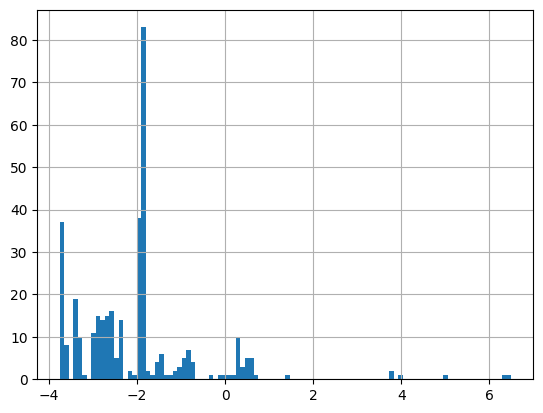

In [16]:
df_dist['energy_per_atom'].hist(bins=100);

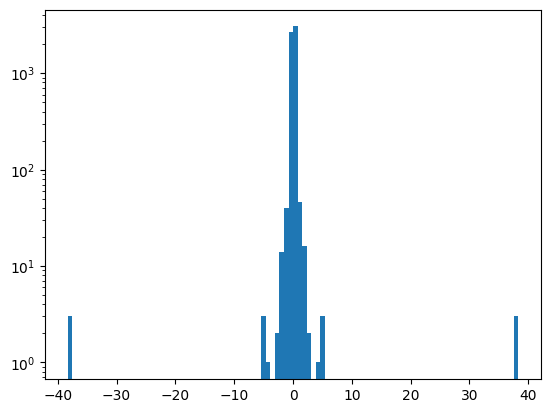

In [17]:
plt.hist(np.vstack(df_dist['forces']).flatten(), bins=100);
plt.yscale('log')

In [18]:
df_dist.to_pickle("distilled_AlLi_dataset.pkl.gz")